<a href="https://colab.research.google.com/github/jaynarayan94/All-Important-Topics-Codes/blob/master/NLP_for_Restaurant_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP for Restaurant Reviews
This notebook aims at using NLP for restaurants to find their advantages and disadvantages and provide some suggestions about how to improve themselves. Also, the notebook realizes applying machine learning model of texts to predict stars.

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import string
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

#Run the below piece of code for the first time
nltk.download('stopwords')
nltk.download('wordnet')
sns.set()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
from google.colab import files

upload = files.upload()

In [0]:
import io

df = pd.read_csv(io.StringIO(upload['yelp.csv'].decode('utf-8')))

In [0]:
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


## Exploratory Data Analysis
* Basic Operations for Data
* Keep meaningful columns and rename variables

In [0]:
#df = df.drop(['business_id', 'date', 'review_id', 'type', 'user_id'],axis=1)

df = df.iloc[:,[3,4,7,8,9]]

df.columns = df.columns.str.capitalize()

df.head()

,Stars,Text,Cool,Useful,Funny
0,5,My wife took me here on my birthday for breakf...,2,5,0
1,5,I have no idea why some people give bad review...,0,0,0
2,4,love the gyro plate. Rice is so good and I als...,0,1,0
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0
4,5,General Manager Scott Petello is a good egg!!!...,0,0,0


In [0]:
df['Text Length'] = df['Text'].apply(len)

df.head()

,Stars,Text,Cool,Useful,Funny,Text Length
0,5,My wife took me here on my birthday for breakf...,2,5,0,889
1,5,I have no idea why some people give bad review...,0,0,0,1345
2,4,love the gyro plate. Rice is so good and I als...,0,1,0,76
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0,419
4,5,General Manager Scott Petello is a good egg!!!...,0,0,0,469


In [0]:
print(df.shape)
print()
print(df.describe())

(10000, 6)

              Stars          Cool        Useful         Funny   Text Length
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000
mean       3.777500      0.876800      1.409300      0.701300    710.738700
std        1.214636      2.067861      2.336647      1.907942    617.399827
min        1.000000      0.000000      0.000000      0.000000      1.000000
25%        3.000000      0.000000      0.000000      0.000000    294.000000
50%        4.000000      0.000000      1.000000      0.000000    541.500000
75%        5.000000      1.000000      2.000000      1.000000    930.000000
max        5.000000     77.000000     76.000000     57.000000   4997.000000


In [0]:
df.isnull().sum()

Stars          0
Text           0
Cool           0
Useful         0
Funny          0
Text Length    0
dtype: int64

A complete data set, without null values. A very good beginning for data analysis

## Data Vasulization - Feature Engineering
* In this part, we will conduct descriptive analysis for all variables and then explore the relationship between 'Stars' and other variables.

### Descriptive Analysis

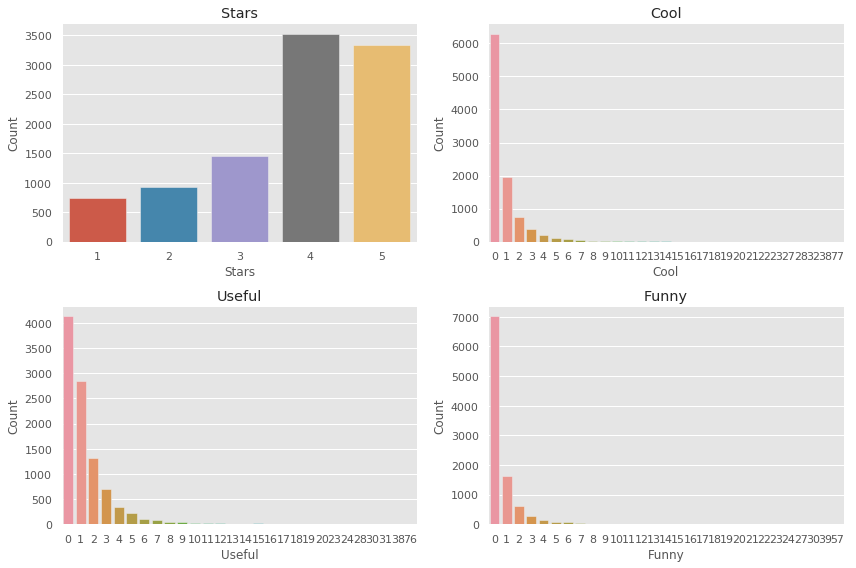

In [0]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(12,8))

ax1 = plt.subplot(2,2,1)
ax1 = sns.countplot(df['Stars'])
ax1.set_title('Stars')
ax1.set_ylabel('Count')


ax2 = plt.subplot(2,2,2)
ax2 = sns.countplot(df['Cool'])
ax2.set_title('Cool')
ax2.set_ylabel('Count')

ax3 = plt.subplot(2,2,3)
ax3 = sns.countplot(df['Useful'])
ax3.set_title('Useful')
ax3.set_ylabel('Count')

ax4 = plt.subplot(2,2,4)
ax4 = sns.countplot(df['Funny'])
ax4.set_title('Funny')
ax4.set_ylabel('Count')

plt.tight_layout()
plt.show()

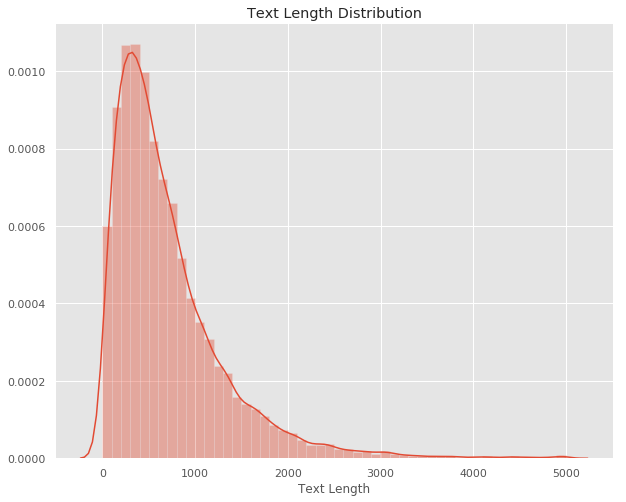

In [0]:
# Text Length
plt.figure(figsize=(10,8))
sns.distplot(df['Text Length'],kde=True,bins=50)
plt.title('Text Length Distribution')
plt.show();

### Checking for Correlation between variables

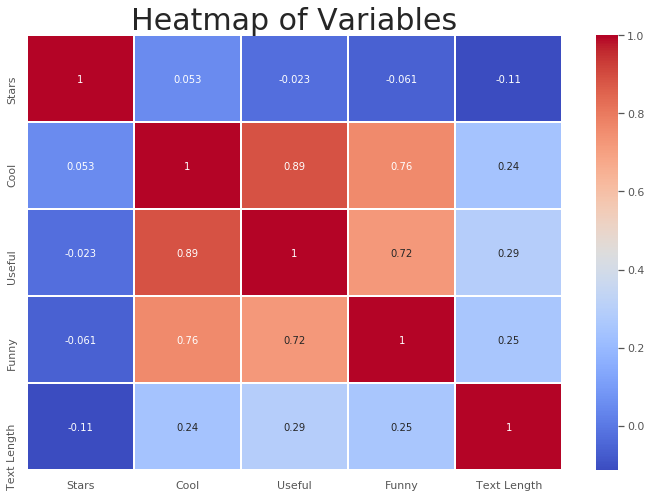

In [0]:
df_cor = df[['Stars', 'Cool', 'Useful', 'Funny', 'Text Length']].corr()

fig = plt.figure(figsize=(12,8))
axes = sns.heatmap(df_cor, cmap='coolwarm', linewidth=1, linecolor='white', annot=True)
axes.set_title('Heatmap of Variables', fontsize=30);

The heatmap shows that there is no correlation between stars and other other variables(the coefficients approximate zero). Let use pairplot to check whether other variables can be used to distinguish 'Stars'

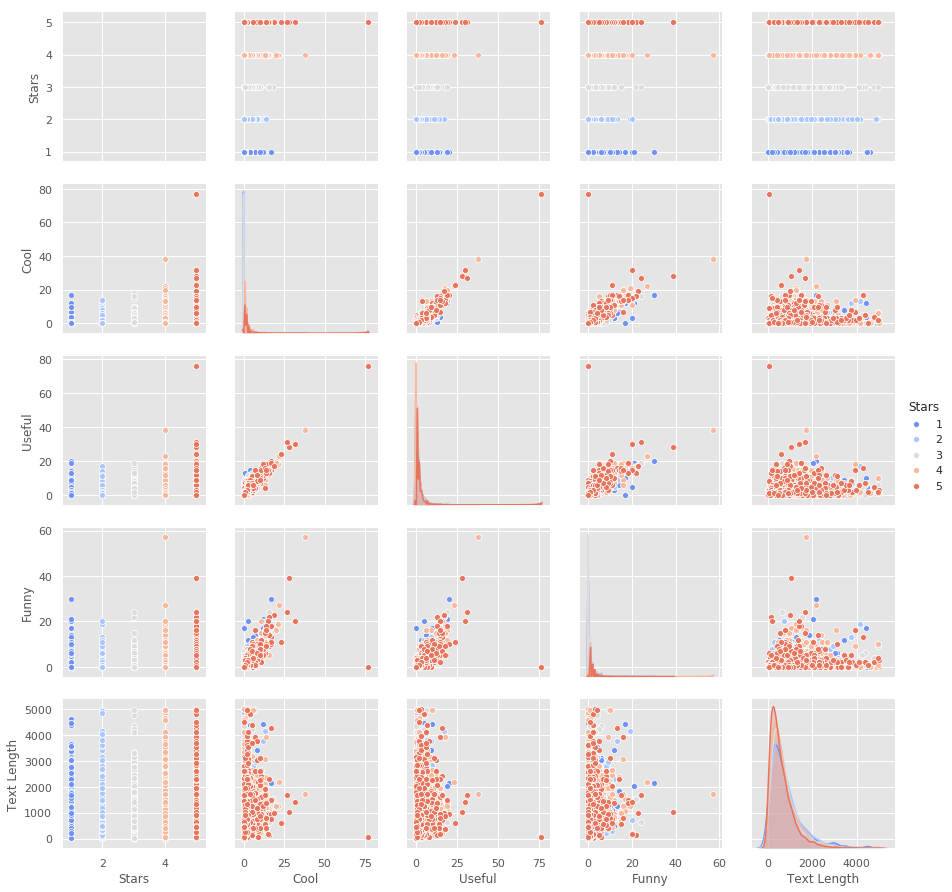

In [0]:
sns.pairplot(df,hue='Stars',palette='coolwarm');

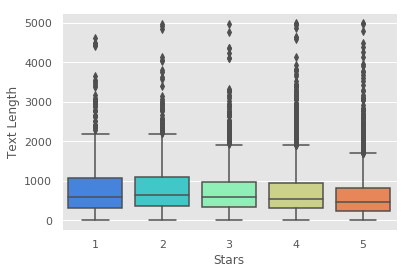

In [0]:
sns.boxplot(x='Stars',y = 'Text Length',data = df, palette ='rainbow');

The heatmap, pairplot and boxplot verify that those other numerical variables cannot be used to predict 'Stars'. Therefore, we have to focus on text analysis.

### Text Analysis
For text analysis, we need to remove all punctuations and stopwords. Then we can get word frequency and make some preparations for further building up model.

In [0]:
df_text = df[['Stars', 'Text']]

df_text.head()

,Stars,Text
0,5,My wife took me here on my birthday for breakf...
1,5,I have no idea why some people give bad review...
2,4,love the gyro plate. Rice is so good and I als...
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
4,5,General Manager Scott Petello is a good egg!!!...


In [0]:
# # For the whole datset Text
# import re

# from nltk.stem.porter import PorterStemmer

# corpus = []

# for i in range(0,10000):
#     review = re.sub(r'[^a-zA-Z]',' ', df_text['Text'][i])

#     review = review.lower()

#     review = review.split()

#     ps = PorterStemmer()

#     review = [ps.stem(word) for word in review if word not in set(stopwords.words('english'))]

#     review  = ' '.join(review)
    
#     corpus.append(review)

In [0]:
def remove_punc_stopword(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    wlm = WordNetLemmatizer()

    remove_punc = [word for word in text if word not in string.punctuation]
    remove_punc = ''.join(remove_punc)
    return [wlm.lemmatize(word).lower().strip() for word in remove_punc.split() if word.lower() not in stopwords.words('english')]

In [0]:
df_text_allstars = df_text.copy()

df_text_allstars['Text'] = df_text_allstars['Text'].apply(remove_punc_stopword)

df_text_allstars.count()

Stars    10000
Text     10000
dtype: int64

In [0]:
df_text_allstars['Text'].head()

0    [wife, took, birthday, breakfast, excellent, w...
1    [idea, people, give, bad, review, place, go, s...
2    [love, gyro, plate, rice, good, also, dig, can...
3    [rosie, dakota, love, chaparral, dog, park, co...
4    [general, manager, scott, petello, good, egg, ...
Name: Text, dtype: object

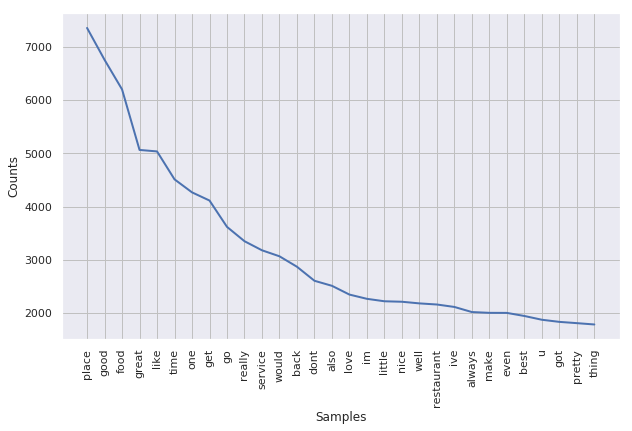

In [0]:
words_split = []
for i in range(0,9999): 
    for word in df_text_allstars['Text'][i]:
        words_split.append(word)
plt.figure(figsize=(10,6))
sns.set()
FreqDist(words_split).plot(30, cumulative=False)

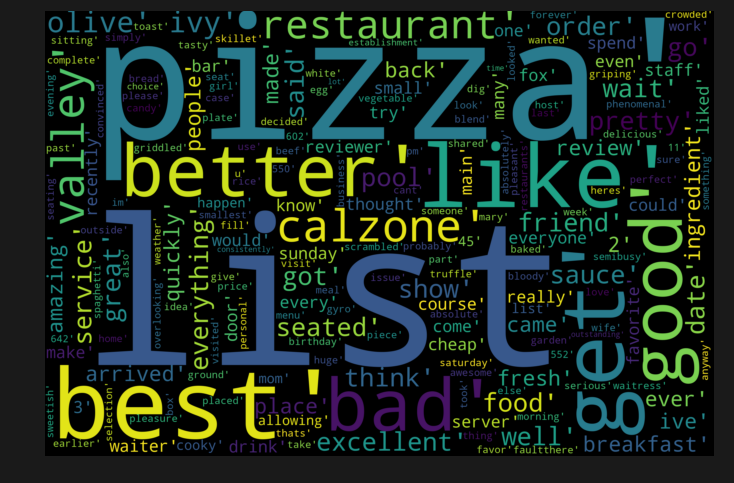

In [0]:
df_allstars_text = df_text_allstars['Text'].values

wordcloud = WordCloud(width =3000,
                     height = 2000,
                     background_color = 'black',
                     stopwords = STOPWORDS).generate(str(df_allstars_text))

fig = plt.figure(figsize=(10,8),facecolor = 'k',edgecolor='k')
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

Stars 1 and 5 Words Frequency and Word Cloud¶

In [0]:
df_text_stars1 = df_text_allstars[df_text_allstars['Stars']==1].reset_index(drop=True)

df_text_stars1.count()

Stars    749
Text     749
dtype: int64

In [0]:
df_text_stars1.head()

,Stars,Text
0,1,"[u, go, n, check, car, u, wanna, buy, 1, thats..."
1,1,"[disgusting, groupon, daughter, tried, outdate..."
2,1,"[ive, eaten, many, time, none, bad, last, nigh..."
3,1,"[always, fan, burlingtons, deal, however, shop..."
4,1,"[another, night, meeting, friend, laugh, waite..."


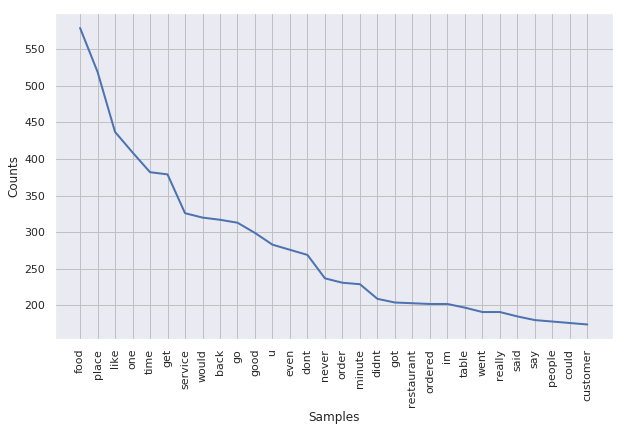

In [0]:
word_split = []

for i in range(1,749):
  for word in df_text_stars1['Text'][i]:
    word_split.append(word)
sns.set()
plt.figure(figsize=(10,6))
FreqDist(word_split).plot(30,cumulative=False)


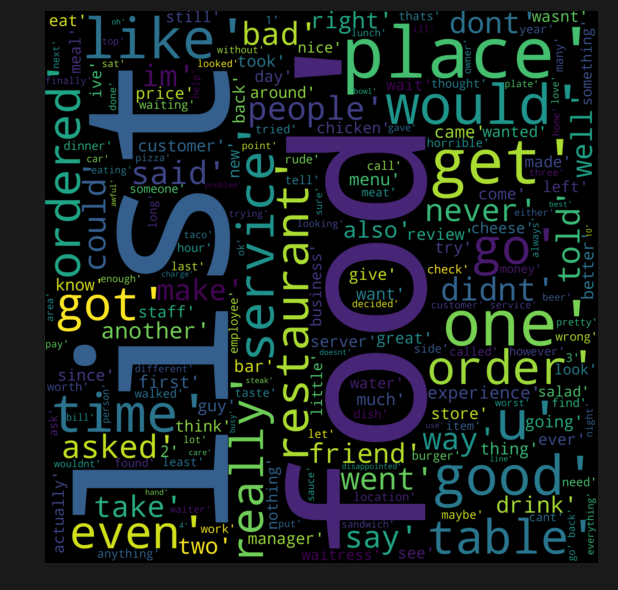

In [0]:
cloud_star1_text = df_text_stars1['Text'].values

wordcloud = WordCloud(height = 3000,
                     width = 3000,
                     background_color = 'black',
                     stopwords = STOPWORDS).generate(str(cloud_star1_text))

plt.figure(figsize=(10,8),facecolor='k',edgecolor='k')
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad = 0)

In [0]:
df_text_stars5 = df_text_allstars[df_text_allstars['Stars']==5].reset_index(drop=True)

df_text_stars5.count()

Stars    3337
Text     3337
dtype: int64

In [0]:
df_text_stars5.head()

,Stars,Text
0,5,"[wife, took, birthday, breakfast, excellent, w..."
1,5,"[idea, people, give, bad, review, place, go, s..."
2,5,"[rosie, dakota, love, chaparral, dog, park, co..."
3,5,"[general, manager, scott, petello, good, egg, ..."
4,5,"[drop, youre, drive, ate, go, back, next, day,..."


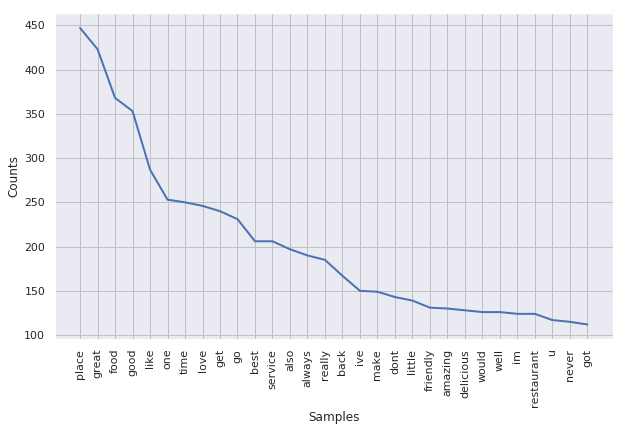

In [0]:
word_split = []

for i in range(1,749):
  for word in df_text_stars5['Text'][i]:
    word_split.append(word)
sns.set()
plt.figure(figsize=(10,6))
FreqDist(word_split).plot(30,cumulative=False)

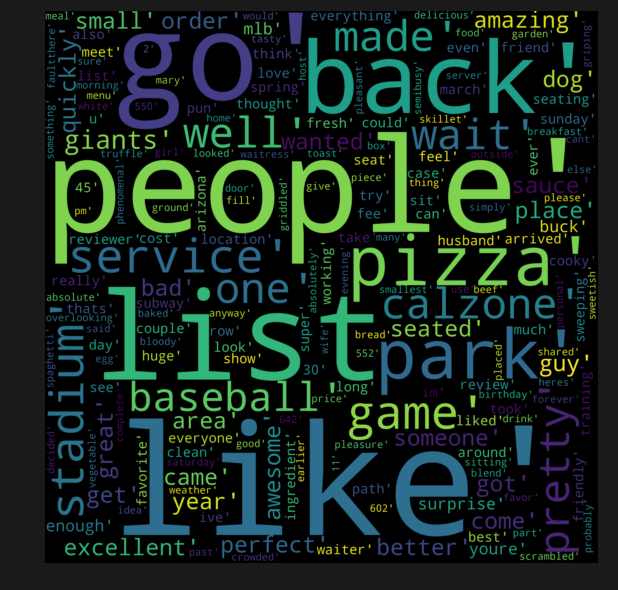

In [0]:
cloud_star5_text = df_text_stars5['Text'].values

wordcloud = WordCloud(height = 3000,
                     width = 3000,
                     background_color = 'black',
                     stopwords = STOPWORDS).generate(str(cloud_star5_text))

plt.figure(figsize=(10,8),facecolor='k',edgecolor='k')
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad = 0)

## Build up ML Model
* ML for All Stars

### ML without TF-IDF
Currently, what we have is 'text', which cannot be recoganized by machine learning model. We need to transfer those texts to vectors that can be used in machine learning model. What's more, let's first build up a machine learning model without using TF-IDF (term frequency-inverse document frequency. The tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus.

In [0]:
X = df_text['Text']
y = df_text['Stars']
cv = CountVectorizer()
X = cv.fit_transform(X)

test_size = np.linspace(0.1, 1, num=9, endpoint=False)
random_state = np.arange(0, 43)
grid_results= []
for testsize in test_size:
    for randomstate in random_state:
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=randomstate)
            mnb = MultinomialNB()
            mnb.fit(X_train, y_train)
            y_test_pred = mnb.predict(X_test)     
            grid_results.append([testsize, randomstate, mean_squared_error(y_test, y_test_pred)])
            grid_frame = pd.DataFrame(grid_results)
            grid_frame.rename(columns={0:'Test Size', 1:'Random State', 2:'MSE of Test'}, inplace=True)
        except Exception:
            print(Exception.with_traceback())
            print('error')
            continue

min_test_mse = grid_frame[grid_frame['MSE of Test'] == grid_frame['MSE of Test'].min()]
min_test_mse

,Test Size,Random State,MSE of Test
21,0.1,21,0.986


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=21)
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_test_pred = mnb.predict(X_test)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           1       0.76      0.51      0.61        69
           2       0.56      0.10      0.17        92
           3       0.25      0.13      0.17       137
           4       0.46      0.68      0.55       373
           5       0.60      0.56      0.58       329

    accuracy                           0.50      1000
   macro avg       0.53      0.40      0.42      1000
weighted avg       0.51      0.50      0.48      1000



## ML using TF-IDF
Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document, measuring how frequently a term occures in document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears, measuring how important a term is.

In [0]:
tfidf_transformer = TfidfTransformer().fit(X)
X = tfidf_transformer.transform(X)

grid_results= []
for testsize in test_size:
    for randomstate in random_state:
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=randomstate)
            mnb = MultinomialNB()
            mnb.fit(X_train, y_train)
            y_test_pred = mnb.predict(X_test)     
            grid_results.append([testsize, randomstate, mean_squared_error(y_test, y_test_pred)])
            grid_frame = pd.DataFrame(grid_results)
            grid_frame.rename(columns={0:'Test Size', 1:'Random State', 2:'MSE of Test'}, inplace=True)
        except Exception:
            print(Exception.with_traceback())
            print('error')
            continue

min_test_mse = grid_frame[grid_frame['MSE of Test'] == grid_frame['MSE of Test'].min()]
min_test_mse

,Test Size,Random State,MSE of Test
31,0.1,31,1.405


In [0]:
pipeline = Pipeline([('bow', CountVectorizer()), 
                     ('tfidf', TfidfTransformer()), 
                     ('classifier', MultinomialNB())])

X = df_text['Text']
y = df_text['Stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=31)
pipeline.fit(X_train, y_train)
y_test_pred = pipeline.predict(X_test)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        99
           3       0.00      0.00      0.00       144
           4       0.40      0.94      0.56       358
           5       0.78      0.35      0.48       338

    accuracy                           0.46      1000
   macro avg       0.24      0.26      0.21      1000
weighted avg       0.41      0.46      0.36      1000

